## Tabular QLearning/SARSA
This is a implementation of the continuous observation environment [MountainCar](https://gym.openai.com/envs/MountainCar-v0) in tabular form.
It was possible to make a tabular version by digitizing the observation space values using the functions [numpy.digitize](https://numpy.org/doc/1.18/reference/generated/numpy.digitize.html) and [numpy.linspace](https://numpy.org/doc/1.18/reference/generated/numpy.linspace.html).<br>
It's a TD algorithm with two options of control (optimization), Q-Learning and SARSA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym

from torch.utils.tensorboard import SummaryWriter

In [2]:
env = gym.make("MountainCar-v0").env

action_space = env.action_space.n
print("Action space:", action_space)

Action space: 3


In [3]:
class Agent():
    def __init__(self, epsilon, position_min, position_max, speed_min, speed_max, alpha, gamma):
        
        self.q_table = {}
        self.epsilon = epsilon
        
        self.discount_factor = gamma
        self.alpha = alpha

        self.position_bins = np.linspace(position_min, position_max, 30)
        self.speed_bins = np.linspace(speed_min, speed_max, 30)

        # populate the q_table
        for pos in self.position_bins:
            for spd in self.speed_bins:
                self.q_table[(pos, spd)] = [0 for _ in range(action_space)]

    def get_state_digitized(self, state):
        pos_dig_i = np.digitize(state[0], self.position_bins)
        pos_dig = self.position_bins[pos_dig_i]

        speed_dig_i = np.digitize(state[1], self.speed_bins)
        speed_dig = self.speed_bins[speed_dig_i]
        return pos_dig, speed_dig

    def get_greedy_action(self, state):
        pos, spd = self.get_state_digitized(state)
        greedy_action = np.argmax(self.q_table[(pos, spd)])
        return greedy_action 

    def get_max_qvalue(self, state):
        pos, spd = self.get_state_digitized(state)
        max_qvalue = np.max(self.q_table[(pos, spd)])
        return max_qvalue 
    
    def get_qvalue(self, state, action):
        pos, spd = self.get_state_digitized(state)
        qvalue = self.q_table[(pos, spd)][action]
        return qvalue 

    def e_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(action_space)
        else:
            action = self.get_greedy_action(state) 
        return action
    
    def td_control(self, state, action, new_state, reward, done, sarsa=False):
        not_done = 1 - done
        
        if sarsa:
            target = reward + self.discount_factor*self.get_qvalue(new_state, action)
            q_value = self.get_qvalue(state, action)
            new_q_value = q_value + self.alpha*(target - q_value)*not_done
        else:
            q_target = reward + self.discount_factor*self.get_max_qvalue(new_state)
            q_value = self.get_qvalue(state, action)
            new_q_value = q_value + self.alpha*(q_target - q_value)*not_done

        # update table
        self.set_qvalue(state, action, new_q_value)

            
    def set_qvalue(self, state, action, value):
        pos, spd = self.get_state_digitized(state)
        self.q_table[(pos, spd)][action] = value

In [4]:
epsilon_init = 0.8
epsilon_end = 0.1
alpha = 0.5 #step-size
discount_factor = 0.99

agent1 = Agent(epsilon_init, env.min_position, env.max_position, -env.max_speed, env.max_speed, alpha=alpha, gamma=discount_factor)
agent2 = Agent(epsilon_init, env.min_position, env.max_position, -env.max_speed, env.max_speed, alpha=alpha, gamma=discount_factor)

In [5]:
# writter for tensorboard
writer = SummaryWriter()
# to see the board run on terminal the following command:
# tensorboard --logdir=runs

In [6]:
def train(agent, n_epochs=200, sarsa=False):
    if sarsa:
        agent_tag = 'SARSA'
    else:
        agent_tag = 'Q-Learning'
    epsilon_discount = (epsilon_init - epsilon_end)/n_epochs
    
    rewards_history = []
    for epoch in range(1, n_epochs+1):

        state = env.reset()
        done = False
        reward_sum = 0

        while not done:
            action = agent.e_greedy_policy(state)
            new_state, reward, done, info = env.step(action)

            reward_sum += reward
            
            agent.td_control(state, action, new_state, reward, done, sarsa=sarsa)
           
            state = new_state
        rewards_history.append(reward_sum)
        writer.add_scalar(f'{agent_tag}/Reward/Train', reward_sum, epoch)
        if epoch % 50 == 0:
            print("Epoch={} \t reward={}\t epsilon={:.4f}".format(epoch, reward_sum, agent.epsilon))
        
        agent.epsilon -= epsilon_discount
    return rewards_history

In [7]:
rewards = train(agent1, n_epochs=2000, sarsa=False)

Epoch=50 	 reward=-3422.0	 epsilon=0.7829
Epoch=100 	 reward=-1300.0	 epsilon=0.7654
Epoch=150 	 reward=-1832.0	 epsilon=0.7479
Epoch=200 	 reward=-490.0	 epsilon=0.7304
Epoch=250 	 reward=-829.0	 epsilon=0.7129
Epoch=300 	 reward=-1270.0	 epsilon=0.6954
Epoch=350 	 reward=-1702.0	 epsilon=0.6779
Epoch=400 	 reward=-1104.0	 epsilon=0.6604
Epoch=450 	 reward=-1781.0	 epsilon=0.6429
Epoch=500 	 reward=-1985.0	 epsilon=0.6254
Epoch=550 	 reward=-693.0	 epsilon=0.6079
Epoch=600 	 reward=-561.0	 epsilon=0.5904
Epoch=650 	 reward=-803.0	 epsilon=0.5729
Epoch=700 	 reward=-408.0	 epsilon=0.5554
Epoch=750 	 reward=-595.0	 epsilon=0.5379
Epoch=800 	 reward=-814.0	 epsilon=0.5204
Epoch=850 	 reward=-751.0	 epsilon=0.5029
Epoch=900 	 reward=-402.0	 epsilon=0.4854
Epoch=950 	 reward=-397.0	 epsilon=0.4679
Epoch=1000 	 reward=-276.0	 epsilon=0.4504
Epoch=1050 	 reward=-450.0	 epsilon=0.4329
Epoch=1100 	 reward=-416.0	 epsilon=0.4154
Epoch=1150 	 reward=-220.0	 epsilon=0.3979
Epoch=1200 	 reward=-52

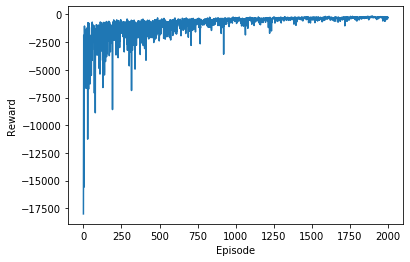

In [8]:
plt.plot(rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [9]:
rewards = train(agent2, n_epochs=2000, sarsa=True)

Epoch=50 	 reward=-1062.0	 epsilon=0.7829
Epoch=100 	 reward=-1027.0	 epsilon=0.7654
Epoch=150 	 reward=-310.0	 epsilon=0.7479
Epoch=200 	 reward=-378.0	 epsilon=0.7304
Epoch=250 	 reward=-513.0	 epsilon=0.7129
Epoch=300 	 reward=-620.0	 epsilon=0.6954
Epoch=350 	 reward=-721.0	 epsilon=0.6779
Epoch=400 	 reward=-666.0	 epsilon=0.6604
Epoch=450 	 reward=-448.0	 epsilon=0.6429
Epoch=500 	 reward=-446.0	 epsilon=0.6254
Epoch=550 	 reward=-540.0	 epsilon=0.6079
Epoch=600 	 reward=-466.0	 epsilon=0.5904
Epoch=650 	 reward=-452.0	 epsilon=0.5729
Epoch=700 	 reward=-544.0	 epsilon=0.5554
Epoch=750 	 reward=-370.0	 epsilon=0.5379
Epoch=800 	 reward=-502.0	 epsilon=0.5204
Epoch=850 	 reward=-567.0	 epsilon=0.5029
Epoch=900 	 reward=-445.0	 epsilon=0.4854
Epoch=950 	 reward=-724.0	 epsilon=0.4679
Epoch=1000 	 reward=-337.0	 epsilon=0.4504
Epoch=1050 	 reward=-517.0	 epsilon=0.4329
Epoch=1100 	 reward=-412.0	 epsilon=0.4154
Epoch=1150 	 reward=-502.0	 epsilon=0.3979
Epoch=1200 	 reward=-396.0	 e

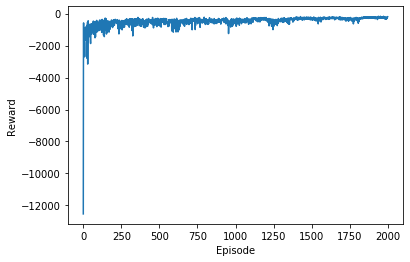

In [10]:
plt.plot(rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [11]:
from time import sleep

def play_game(agent):
    for i in range(3):
        state = env.reset()
        done = False
        reward_sum = 0
        while not done:
            env.render()
            action = agent.get_greedy_action(state)

            state, reward, done, _ = env.step(action)
            reward_sum += reward

            sleep(0.01)
        print("Episode finished. Reward={:.4f}".format(reward_sum))

In [12]:
play_game(agent=agent1)

Episode finished. Reward=-251.0000
Episode finished. Reward=-233.0000
Episode finished. Reward=-250.0000
